<a href="https://colab.research.google.com/github/CaptainDilawar/AI-Powered-Product-Photography-Tool/blob/main/Image_Composition_Phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install requests rembg pillow ipywidgets onnxruntime -q
!pip install opencv-python-headless -q
print("✅ All libraries installed successfully!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.4 MB/s eta 0:00:00
✅ All libraries installed successfully!


In [3]:
import os
import getpass
HF_API_TOKEN = getpass.getpass('Enter your Hugging Face API Key: ')
SCENE_GENERATION_API_URL = "https://api-inference.huggingface.co/models/stabilityai/stable-diffusion-xl-base-1.0"
headers = {"Authorization": f"Bearer {HF_API_TOKEN}"}

print("✅ API Key configured.")

Enter your Hugging Face API Key: ··········
✅ API Key configured.


In [4]:
import ipywidgets as widgets
from IPython.display import display
import io
from PIL import Image
uploader = widgets.FileUpload(
    accept='image/*',  # Allow any image type
    multiple=False    # We only want one file
)
prompt_text = widgets.Text(
    value='A product on a marble kitchen counter, professional studio lighting',
    placeholder='Type your scene description...',
    description='Prompt:',
    disabled=False,
    layout=widgets.Layout(width='80%')
)

print("Please upload your product image and write a prompt for the background scene.")
display(uploader, prompt_text)

Please upload your product image and write a prompt for the background scene.


FileUpload(value={}, accept='image/*', description='Upload')

Text(value='A product on a marble kitchen counter, professional studio lighting', description='Prompt:', layou…

G.R.A.I.L : Engineering a high-quality prompt from user input: 'product on a yellow silk cloth'
G.R.A.I.L : Final AI Positive Prompt: 'A professional photograph of on a yellow silk cloth, a clean empty surface with copy space in the center, soft studio lighting, highly detailed, sharp focus, 4k'
G.R.A.I.L : Final AI Negative Prompt: 'product, object, item, bottle, text, watermark, person, logo, ring, jewelry, hand'
G.R.A.I.L : (1/3) Removing background from product...
G.R.A.I.L : (2/3) Generating background scene... (This may take up to a minute)
G.R.A.I.L : (3/3) Compositing image...
      -> Applying color harmonization with 30% strength...

[SUCCESS] ---- Process Complete! ---- [SUCCESS]


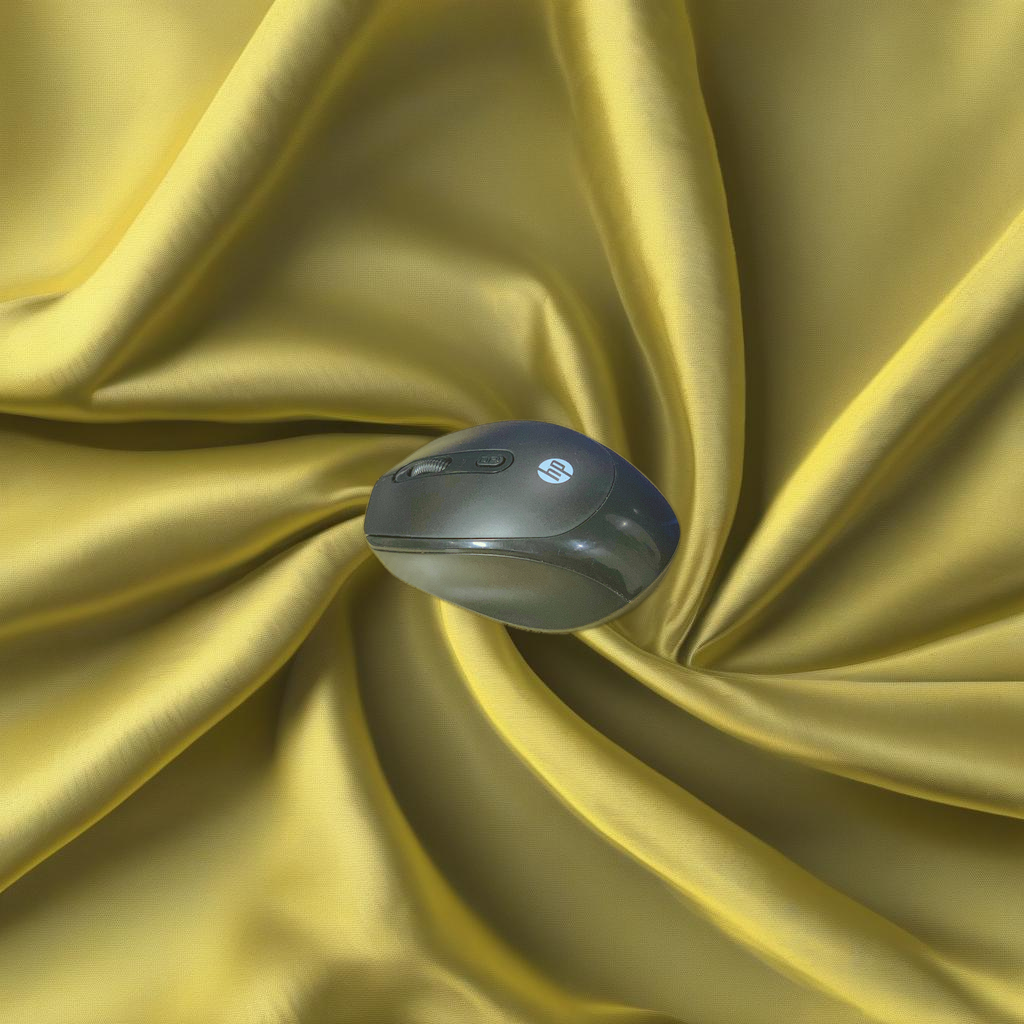

In [6]:
# @title ← Run this cell to generate the final image! (Final Version with Strength Control)

# Make sure to run the install cell with: !pip install opencv-python-headless -q
import cv2
import numpy as np
from rembg import remove
import requests
from PIL import Image
import io

# --- Existing functions from your code go here ---
# (Make sure to define SCENE_GENERATION_API_URL and headers in a previous cell)
def sanitize_for_print(text: str) -> str: return text.encode('utf-8', 'replace').decode('utf-8')
def engineer_prompt(user_instruction):
    print(f"G.R.A.I.L : Engineering a high-quality prompt from user input: '{user_instruction}'")
    cleaned_instruction = user_instruction.lower().replace('product', '').strip()
    positive_template = ("A professional photograph of {subject}, a clean empty surface with copy space in the center, soft studio lighting, highly detailed, sharp focus, 4k")
    negative_prompt = "product, object, item, bottle, text, watermark, person, logo, ring, jewelry, hand"
    final_positive_prompt = positive_template.format(subject=cleaned_instruction)
    print(f"G.R.A.I.L : Final AI Positive Prompt: '{final_positive_prompt}'")
    print(f"G.R.A.I.L : Final AI Negative Prompt: '{negative_prompt}'")
    return {"positive": final_positive_prompt, "negative": negative_prompt}
def remove_background(image_data):
    print("G.R.A.I.L : (1/3) Removing background from product...")
    output_bytes = remove(image_data)
    return Image.open(io.BytesIO(output_bytes))
def generate_scene(prompt_dict):
    print("G.R.A.I.L : (2/3) Generating background scene... (This may take up to a minute)")
    payload = {"inputs": prompt_dict["positive"], "parameters": {"negative_prompt": prompt_dict["negative"]}}
    response = requests.post(SCENE_GENERATION_API_URL, headers=headers, json=payload)
    response.encoding = 'utf-8'
    if response.status_code != 200: raise Exception(f"Error from API: {response.text}")
    return Image.open(io.BytesIO(response.content))
# --- End of existing functions ---


# --- UPGRADED FUNCTION: Color Harmonization with Strength Control ---
def harmonize_color(product_img, background_img, strength=0.3):
    """
    Adjusts the product's color and blends it with the original to control the effect.
    A strength of 0.0 is no effect, 1.0 is full effect.
    """
    # 1. Calculate the fully harmonized color (as before)
    product_cv = cv2.cvtColor(np.array(product_img), cv2.COLOR_RGBA2RGB)
    background_cv = cv2.cvtColor(np.array(background_img), cv2.COLOR_RGB2BGR)
    product_lab = cv2.cvtColor(product_cv, cv2.COLOR_RGB2LAB)
    background_lab = cv2.cvtColor(background_cv, cv2.COLOR_BGR2LAB)
    l_prod, a_prod, b_prod = cv2.split(product_lab)
    l_prod = l_prod.astype("float")
    a_prod = a_prod.astype("float")
    b_prod = b_prod.astype("float")
    l_bg, a_bg, b_bg = cv2.split(background_lab)
    (l_mean_bg, l_std_bg) = cv2.meanStdDev(l_bg)
    (a_mean_bg, a_std_bg) = cv2.meanStdDev(a_bg)
    (b_mean_bg, b_std_bg) = cv2.meanStdDev(b_bg)
    (l_mean_prod, l_std_prod) = cv2.meanStdDev(l_prod)
    (a_mean_prod, a_std_prod) = cv2.meanStdDev(a_prod)
    (b_mean_prod, b_std_prod) = cv2.meanStdDev(b_prod)
    l_prod -= l_mean_prod
    a_prod -= a_mean_prod
    b_prod -= b_mean_prod
    l_prod = (l_std_bg / l_std_prod) * l_prod if l_std_prod > 0 else l_prod
    a_prod = (a_std_bg / a_std_prod) * a_prod if a_std_prod > 0 else a_prod
    b_prod = (b_std_bg / b_std_prod) * b_prod if b_std_prod > 0 else b_prod
    l_prod += l_mean_bg
    a_prod += a_mean_bg
    b_prod += b_mean_bg
    l_prod = np.clip(l_prod, 0, 255)
    a_prod = np.clip(a_prod, 0, 255)
    b_prod = np.clip(b_prod, 0, 255)
    matched_lab = cv2.merge([l_prod, a_prod, b_prod])
    matched_rgb = cv2.cvtColor(matched_lab.astype("uint8"), cv2.COLOR_LAB2RGB)
    fully_harmonized_product = Image.fromarray(matched_rgb)

    # 2. --- THIS IS THE FIX ---
    # Blend the original product color with the fully harmonized color
    # Image.blend() takes two images and a mixing factor (alpha)
    original_product_rgb = product_img.convert("RGB")
    blended_product = Image.blend(original_product_rgb, fully_harmonized_product, alpha=strength)

    # 3. Re-apply the original alpha mask to the blended result
    blended_product.putalpha(product_img.getchannel('A'))

    return blended_product


# --- Step 3: Composition (Calling the upgraded function) ---
def compose_images(product_cutout, background_scene):
    print("G.R.A.I.L : (3/3) Compositing image...")
    bg_w, bg_h = background_scene.size
    if product_cutout.width == 0 or product_cutout.height == 0: raise ValueError("Background removal resulted in an empty image.")
    product_ratio = product_cutout.width / product_cutout.height
    new_h = int(bg_h * 0.6)
    new_w = int(new_h * product_ratio)
    product_resized = product_cutout.resize((new_w, new_h), Image.LANCZOS)

    # We now call harmonize_color with a specific strength.
    # This is the "magic knob" you can tune!
    print("      -> Applying color harmonization with 30% strength...")
    harmonized_product = harmonize_color(product_resized, background_scene, strength=0.3)

    final_image = background_scene.copy().convert("RGBA")
    product_pos = ((bg_w - new_w) // 2, (bg_h - new_h) // 2)
    final_image.paste(harmonized_product, product_pos, harmonized_product)

    return final_image.convert("RGB")


# --- Main Execution Block ---
try:
    # (Your existing main block code should work fine here)
    uploaded_file = uploader.value
    if not uploaded_file: print("[ERROR] Please upload an image in Cell 3 first!")
    else:
        input_image_data = list(uploaded_file.values())[0]['content']
        user_prompt = prompt_text.value
        engineered_prompts = engineer_prompt(user_prompt)
        product_cutout = remove_background(input_image_data)
        background_scene = generate_scene(engineered_prompts)
        final_image = compose_images(product_cutout, background_scene)
        print("\n[SUCCESS] ---- Process Complete! ---- [SUCCESS]")
        display(final_image)
except Exception as e:
    sanitized_error = sanitize_for_print(str(e))
    print(f"[ERROR] An error occurred during the process: {sanitized_error}")